# Set random seed for everything

In [ ]:
import numpy as np
import random
import torch
import os

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

def reset_seed():
    np.random.seed()
    random.seed()
    torch.seed()
    torch.cuda.seed()
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
    os.environ["PYTHONHASHSEED"] = ''
    print('random seed is again random')


# Standalone shadow model

#### Load and split the data

In [ ]:
import pandas as pd
import missingno as msno
import numpy as np
from sklearn.model_selection import train_test_split

# load the data
df = pd.read_csv('/content/dataset.csv')

X = df.drop(columns=['target'])
y = df['target']
num_of_classes = y.nunique()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

#### Train the shadow model

Random seed set as 42


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6/100, Train Loss: 0.0170, Test Loss: 0.4025
Early stopping triggered.


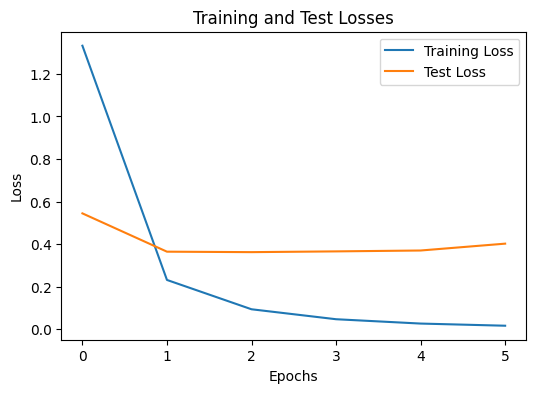

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.notebook import tqdm

set_seed()

# Hyperparameters for the shadow model
input_size = X_train.shape[1]
output_size = len(set(y_train))
hidden_size = 64
learning_rate = 0.005
epochs = 100
batch_size = 64
patience = 3


# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)

class ShadowModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ShadowModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

shadow_model = ShadowModel(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(shadow_model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

best_test_loss = float('inf')
patience_counter = 0

# Train
for epoch in tqdm(range(epochs), desc='Epochs'):

    shadow_model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = shadow_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Test
    shadow_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = shadow_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_dataset)
    test_losses.append(test_loss)

    print(f'\rEpoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}', end='', flush=True)

    # Check for early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("\nEarly stopping triggered.")
            break

# Plot the loss for each epoch
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()


#### Create an attack dataset

In [ ]:
import torch
import torch.nn.functional as F

in_samples = 3500
out_samples = 3500
random_state = 41

X_member_sample = X_train.sample(n=in_samples, random_state=random_state)
X_non_member_sample = X_test.sample(n=out_samples, random_state=random_state)

X_member_sample_tensor = torch.tensor(X_member_sample.values, dtype=torch.float32)
X_non_member_sample_tensor = torch.tensor(X_non_member_sample.values, dtype=torch.float32)

shadow_member_outputs =  F.softmax(shadow_model(X_member_sample_tensor), dim=1)
shadow_non_member_outputs = F.softmax(shadow_model(X_non_member_sample_tensor), dim=1)

# create a df from the outputs of the shadow model
attack_df = pd.concat([pd.DataFrame(shadow_member_outputs.detach().numpy()), pd.DataFrame(shadow_non_member_outputs.detach().numpy())])

# add a target column that is whether the datapoint was member of the training of the shadow model or not
attack_df['membership'] = [True] * in_samples + [False] * out_samples
attack_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,membership
0,3.291465e-10,4.579849e-07,0.00004,0.987368,0.000029,0.000003,0.000002,5.729730e-08,3.167076e-07,2.359996e-08,0.000055,0.000008,0.000001,0.000001,0.000002,0.000545,0.011944,4.483681e-08,True


#### Train the attack model and check metrics

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

X_attack = attack_df.drop(columns=['membership'])
y_attack = attack_df['membership']

X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(X_attack, y_attack, test_size=0.2, random_state=random_state)

attack_model = RandomForestClassifier(n_estimators=100, random_state=random_state)
attack_model.fit(X_attack_train, y_attack_train)

y_attack_pred = attack_model.predict(X_attack_test)
test_precision = precision_score(y_attack_test, y_attack_pred)

print("Test Precision:", test_precision)

test_accuracy = attack_model.score(X_attack_test, y_attack_test)
print("Test Accuracy:", test_accuracy)


# Complete Attack

In [ ]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

set_seed()


df = pd.read_csv('/content/dataset.csv')

X = df.drop(columns=['target'])
y = df['target']
num_of_classes = y.nunique()

# Hyperparameters for the shadow model
random_state = 42
hidden_size = 128
learning_rate = 0.0001
epochs = 100
batch_size = 32
patience = 4
number_of_shadows = 20

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

# Define a simple neural network for the shadow model
class ShadowModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ShadowModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


for model_idx in tqdm(range(number_of_shadows), desc='Shadow Models Training'):

    input_size = X_train.shape[1]  # Adjust based on your input features
    output_size = len(set(y_train))  # Number of classes

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    # Create DataLoader for training and test sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    # print(f'\nTraining shadow model {model_idx+1}/{number_of_shadows}...')
    test_losses = []

    best_test_loss = float('inf')
    patience_counter = 0

    # Instantiate the shadow model
    shadow_model = ShadowModel(input_size, hidden_size, output_size)

    # Define loss and optimizer for the shadow model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(shadow_model.parameters(), lr=learning_rate)

    # Lists to store loss values for each epoch
    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience_counter = 0


    # Train the shadow model
    for epoch in range(epochs):

        shadow_model.train()
        running_loss = 0.0

        for inputs, labels in train_dataloader:

            optimizer.zero_grad()
            outputs = shadow_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)


        epoch_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_loss)

        # validation
        shadow_model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = shadow_model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
        test_loss /= len(test_dataset)
        test_losses.append(test_loss)

        print(f'\rEpoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}', end='', flush=True)

        # Check for early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("\r\nEarly stopping triggered.", end='', flush=True)
                break

    # plt.figure(figsize=(6, 4))
    # plt.plot(train_losses, label='Training Loss')
    # plt.plot(test_losses, label='Test Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Training and Test Losses')
    # plt.legend()
    # plt.show()

    # print(f'\rGenerating shadow model responses for model {model_idx+1}/{number_of_shadows}...', flush=True)
    in_samples = 3500
    out_samples = 3500

    X_member_sample = X_train.sample(n=in_samples, random_state=random_state)
    X_non_member_sample = X_test.sample(
        n=out_samples, random_state=random_state)

    X_member_sample_tensor = torch.tensor(
        X_member_sample.values, dtype=torch.float32)
    X_non_member_sample_tensor = torch.tensor(
        X_non_member_sample.values, dtype=torch.float32)

    shadow_member_outputs =  F.softmax(shadow_model(X_member_sample_tensor), dim=1)
    shadow_non_member_outputs = F.softmax(shadow_model(X_non_member_sample_tensor), dim=1)


    # create a df from the outputs of the shadow model
    attack_df = pd.concat([pd.DataFrame(shadow_member_outputs.detach(
    ).numpy()), pd.DataFrame(shadow_non_member_outputs.detach().numpy())])

    # add a target column that is whether the datapoint was member of the training of the shadow model or not
    attack_df['membership'] = [True] * in_samples + [False] * out_samples

    if model_idx == 0:
        attack_df_all = attack_df
    else:
        attack_df_all = pd.concat([attack_df_all, attack_df])

Shadow Models Training:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 50/100, Train Loss: 0.0434, Test Loss: 0.3569
Early stopping triggered.
Epoch 48/100, Train Loss: 0.0476, Test Loss: 0.3582
Early stopping triggered.
Epoch 47/100, Train Loss: 0.0482, Test Loss: 0.3575
Early stopping triggered.
Epoch 49/100, Train Loss: 0.0457, Test Loss: 0.3530
Early stopping triggered.
Epoch 48/100, Train Loss: 0.0449, Test Loss: 0.3499
Early stopping triggered.
Epoch 46/100, Train Loss: 0.0518, Test Loss: 0.3588
Early stopping triggered.
Epoch 50/100, Train Loss: 0.0427, Test Loss: 0.3592
Early stopping triggered.
Epoch 49/100, Train Loss: 0.0443, Test Loss: 0.3661
Early stopping triggered.
Epoch 50/100, Train Loss: 0.0427, Test Loss: 0.3550
Early stopping triggered.
Epoch 50/100, Train Loss: 0.0430, Test Loss: 0.3617
Early stopping triggered.
Epoch 50/100, Train Loss: 0.0416, Test Loss: 0.3587
Early stopping triggered.
Epoch 50/100, Train Loss: 0.0418, Test Loss: 0.3576
Early stopping triggered.
Epoch 49/100, Train Loss: 0.0447, Test Loss: 0.3550
Early stopp

#### Train the attack model on all shadow models data combined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

attack_df_all = attack_df_all.sample(frac=1, replace=False).reset_index(drop=True)

X_attack = attack_df_all.drop(columns=['membership'])
y_attack = attack_df_all['membership']

X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(X_attack, y_attack, test_size=0.2, random_state=random_state)

attack_model = RandomForestClassifier(n_estimators=100, random_state=random_state)
attack_model.fit(X_attack_train, y_attack_train)

y_attack_pred = attack_model.predict(X_attack_test)
test_precision = precision_score(y_attack_test, y_attack_pred)
print("Test Precision:", test_precision)


test_accuracy = attack_model.score(X_attack_test, y_attack_test)
print("Test Accuracy:", test_accuracy)

# best one
# Test Precision: 0.7334391114637049
# Test Accuracy: 0.7467857142857143

Test Precision: 0.7427762785493319
Test Accuracy: 0.7653928571428571


### ROC plot

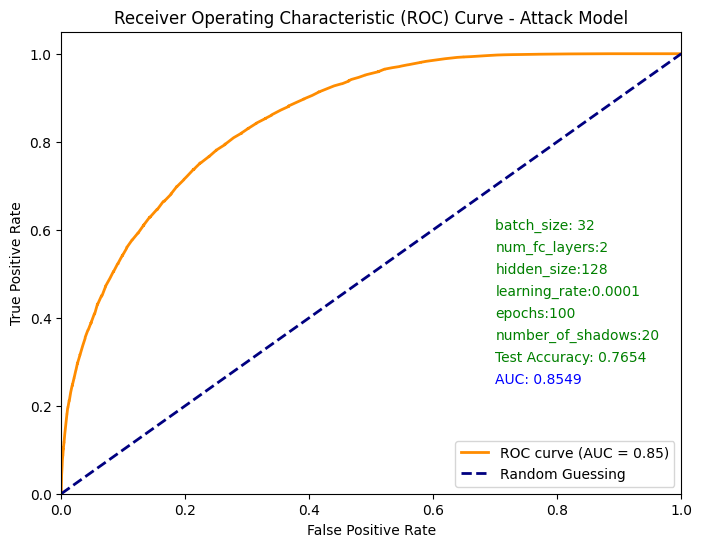

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_attack_probs = attack_model.predict_proba(X_attack_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_attack_test, y_attack_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Attack Model')
plt.legend(loc='lower right')

num_fc_layers = sum(1 for module in shadow_model.modules() if isinstance(module, nn.Linear))

plt.text(0.7, 0.6, f'batch_size: {batch_size}' , fontsize=10, color='green')
plt.text(0.7, 0.55, f'num_fc_layers:{num_fc_layers}' , fontsize=10, color='green')
plt.text(0.7, 0.5, f'hidden_size:{hidden_size}' , fontsize=10, color='green')
plt.text(0.7, 0.45, f'learning_rate:{learning_rate}', fontsize=10, color='green')
plt.text(0.7, 0.4, f'epochs:{epochs}', fontsize=10, color='green')
plt.text(0.7, 0.35, f'number_of_shadows:{number_of_shadows}', fontsize=10, color='green')

plt.text(0.7, 0.3, f'Test Accuracy: {test_accuracy:.4f}', fontsize=10, color='green')
plt.text(0.7, 0.25, f'AUC: {roc_auc:.4f}', fontsize=10, color='blue')


plt.show()


### use this to submit to kaggle

In [ ]:
import numpy as np
import pandas as pd
import torch


def get_dataset(path="dataset/dataset.csv"):
    """Loads a csv file and transforms the dataframe to numpy array"""
    # read csv
    data = pd.read_csv(path, header=0)
    # print(data['target'].value_counts())

    # get X, y
    columns = list(data.columns)
    columns = columns[:len(columns) - 1]
    X = data.loc[:, columns].to_numpy()
    y = data.target.to_numpy().ravel()

    num_classes = len(np.unique(y))  # get number of classes
    dataset = X, y
    return dataset, num_classes


def test(model, data, prob=False):
    """Makes predictions on the given data using the given model.
       It returns the accuracy or the probabilities per instance and the accuracy if prob=True"""
    model.eval()  # evaluation mode

    correct = 0  # ininitalize correct predictions
    probabilities = []  # list to store prediction probabilities per sample

    X, y = data
    if prob:  # use softmax to generate probabilities
        softmax = torch.nn.Softmax(dim=0)
    with torch.no_grad():
        for i in range(len(X)):
            tmp_x, tmp_y = torch.from_numpy(X[i]).float(), int(y[i])  # transform numpy X to torch tensor
            out = model(tmp_x)  # make a prediction
            if prob:
                probability = softmax(out)  # calculate the probabilities
                probabilities.append(probability.flatten().tolist())
            pred = out.argmax().item()  # get the predicted class

            if pred == tmp_y:  # increment correct predictions
                correct += 1

    accuracy = correct / len(X)  # calculate accuracy

    if prob:
        return probabilities, accuracy

    return accuracy


data, num_classes = get_dataset(path="/content/dataset.csv")
print("Found", num_classes, "classes")

model_path = "/content/model_scripted.pt"
model = torch.jit.load(model_path)

probabilities, accuracy = test(model, data, prob=True)
print(probabilities[0])
print(accuracy)



Found 18 classes
[1.7854827938806642e-18, 5.351409300747896e-19, 1.2584114501210298e-19, 0.999875545501709, 4.614029210786574e-12, 1.1084993266654138e-20, 3.9504491694307496e-17, 5.31124296116597e-19, 4.483755257810532e-19, 2.8307355980851056e-22, 8.738201574160644e-20, 1.3448413034294053e-18, 3.449246208778334e-17, 2.1116512246498042e-19, 7.51056344002509e-20, 1.6812565784007916e-09, 0.00012438073463272303, 8.09204917991847e-24]
0.8958413801982748


In [ ]:
target_model_prob_df = pd.DataFrame(probabilities)
target_model_prob_df.head(5)
# attack_df_all.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.785483e-18,5.351409e-19,1.258411e-19,0.999876,4.614029e-12,1.108499e-20,3.950449e-17,5.311243e-19,4.483755e-19,2.830736e-22,8.738202e-20,1.344841e-18,3.449246e-17,2.111651e-19,7.510563e-20,1.681257e-09,1.243807e-04,8.092049e-24
1,2.001131e-07,1.801353e-06,1.899402e-06,0.999971,1.641017e-06,1.807291e-06,1.099833e-06,2.522198e-06,8.341641e-07,3.323142e-07,1.029086e-05,1.349727e-06,1.144516e-06,1.439633e-06,1.013142e-06,3.474744e-07,8.297764e-07,1.088038e-07
2,3.051667e-12,1.820553e-11,4.277510e-11,1.000000,1.427539e-10,5.190588e-11,7.749383e-11,9.208836e-11,1.688348e-11,3.005341e-12,1.119164e-09,1.999136e-10,1.146773e-10,7.816436e-11,1.817645e-11,3.194654e-10,2.693327e-09,3.040887e-13
3,7.334526e-12,8.046240e-14,1.193448e-12,0.000035,6.131235e-05,7.832135e-14,1.043254e-11,6.568481e-13,3.638575e-13,2.459672e-14,6.350573e-14,8.304665e-14,8.894791e-12,1.517429e-13,1.075183e-13,9.999002e-01,3.454282e-06,2.753292e-16
4,5.361021e-07,7.649858e-07,1.177370e-06,0.008540,9.914185e-01,3.275742e-07,8.707823e-07,2.324722e-07,3.866899e-06,6.628196e-07,1.302827e-06,1.194377e-06,1.296322e-05,2.179193e-07,2.068634e-06,4.843364e-06,9.964768e-06,1.245802e-07


In [ ]:
target_model_prob_df = pd.DataFrame(probabilities)

predictions = attack_model.predict(target_model_prob_df)

# Print the predictions
print(predictions)

dictionary = {'index': list(range(len(predictions))), 'Prediction': list(map(int, predictions))}

df_to_csv = pd.DataFrame(dictionary)
df_to_csv.to_csv('output_attack_predictions_4.csv', index=None)
df_to_csv

[ True False False ...  True  True  True]


,index,Prediction
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
7762,7762,1
7763,7763,1
7764,7764,1
7765,7765,1
